In [3]:
%load_ext autoreload
%autoreload 2

from fastai.text.all import *
from fastai.vision.all import *
import pandas as pd
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

In [5]:
path = Path("/mnt/nas/backups/08-07-2020/desktopg01/lisa/Data/small_flow")

In [41]:
def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   splitter=GrandparentSplitter(valid_name="val"),
                   item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=size, min_scale=0.75,
                                               do_flip=False, max_rotate=3,
                                               ),
                               Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path, bs=bs)

In [42]:
dls = get_dls(64, 224)

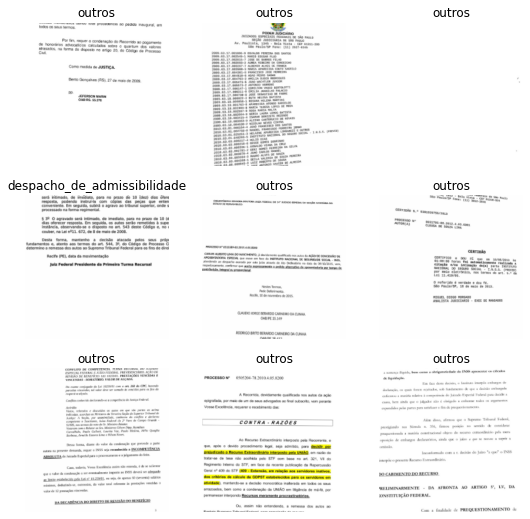

In [43]:
dls.show_batch()

In [39]:
model = torch.hub.load('XingangPan/IBN-Net', 'resnet50_ibn_a', pretrained=True)

Downloading: "https://github.com/XingangPan/IBN-Net/archive/master.zip" to /mnt/home/peluz/.cache/torch/hub/master.zip
Downloading: "https://github.com/XingangPan/IBN-Net/releases/download/v1.0/resnet50_ibn_a-d9d0bb7b.pth" to /mnt/home/peluz/.cache/torch/hub/checkpoints/resnet50_ibn_a-d9d0bb7b.pth


In [44]:
fscore = F1Score(average='weighted')

In [66]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, fscore])

In [67]:
learn.summary()

ResNet_IBN (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 112 x 112  9,408      True      
________________________________________________________________
BatchNorm2d          64 x 64 x 112 x 112  128        True      
________________________________________________________________
ReLU                 64 x 64 x 112 x 112  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 56 x 56    0          False     
________________________________________________________________
Conv2d               64 x 64 x 56 x 56    4,096      True      
________________________________________________________________
InstanceNorm2d       64 x 32 x 56 x 56    64         True      
________________________________________________________________
BatchNorm2d          64 x 32 x 56 x 56    64         True      
_________________________________________________

In [69]:
learn.freeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, 1e-2)